In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['Arial'],#['Times New Roman'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

In [2]:
def get_data(model_id,data,file):

    td = np.load('./'+file+'/databygroup.npy',allow_pickle=True).tolist()
    for k in td.keys():
        if model_id == 'MLP':
            data['yt'][k]=td[k][:,[-5,-4,-3,-2,-1]]
        elif model_id == 'LSTM' or model_id == 'BLSTM_ATT':
            n=td[k].shape[0]
            data['yt'][k]=td[k][:n-20-1,[-5,-4,-3,-2,-1]]
        else:
            n=td[k].shape[0]
            data['yt'][k]=td[k][:n-20-1,[-5,-4,-3,-2,-1]]

    for f in td.keys():
        data['yp'][f]=pd.read_csv('./'+file+'/results/'+model_id+'/results_'+f).values[:,1:]

def get_mae(data,file):
    # 不是每一类数据都有MSE，而是每次预测都有MSE
    datamaxmin=np.load('./'+file+'/databygroup_maxmin.npy',allow_pickle=True).tolist()
    datamax,datamin = datamaxmin['max'],datamaxmin['min']
    tem = []
    for k in data['yp'].keys():
        for i in range(data['yp'][k].shape[0]):
            datay = data['yp'][k][i]
            datayT = data['yt'][k][i]
            tem.append(np.mean(np.square(datay-datayT)))
        
    data['mse']=tem


In [3]:
model_id='LSTM'
alldataLSTM={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,alldataLSTM,'Step4_DNN-alldata')

augdataLSTM={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,augdataLSTM,'Step4_DNN-augdata')

scendataLSTM={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,scendataLSTM,'Step4_DNN-scenariodata')

get_mae(augdataLSTM,'Step4_DNN-augdata')
get_mae(alldataLSTM,'Step4_DNN-alldata')
get_mae(scendataLSTM,'Step4_DNN-scenariodata')

In [4]:
model_id='BLSTM_ATT'
alldataATT={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,alldataATT,'Step4_DNN-alldata')


augdataATT={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,augdataATT,'Step4_DNN-augdata')

scendataATT={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,scendataATT,'Step4_DNN-scenariodata')

get_mae(augdataATT,'Step4_DNN-augdata')
get_mae(alldataATT,'Step4_DNN-alldata')
get_mae(scendataATT,'Step4_DNN-scenariodata')

In [5]:
model_id='XGBoost'
alldataXGB={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,alldataXGB,'Step4_DNN-alldata')


augdataXGB={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,augdataXGB,'Step4_DNN-augdata')

scendataXGB={'yp':{},
         'yt':{},
         'mse':{}}
get_data(model_id,scendataXGB,'Step4_DNN-scenariodata')

get_mae(augdataXGB,'Step4_DNN-augdata')
get_mae(alldataXGB,'Step4_DNN-alldata')
get_mae(scendataXGB,'Step4_DNN-scenariodata')

In [6]:
print('all data LSTM: ',np.mean(alldataLSTM['mse']))
print('representative data LSTM: ',np.mean(augdataLSTM['mse']))
print('scenario data LSTM: ',np.mean(scendataLSTM['mse']))

#######################################################

print('all data ATT: ',np.mean(alldataATT['mse']))
print('representative data ATT: ',np.mean(augdataATT['mse']))
print('scenario data ATT: ',np.mean(scendataATT['mse']))


#######################################################

print('all data XGB: ',np.mean(alldataXGB['mse']))
print('representative data XGB: ',np.mean(augdataXGB['mse']))
print('scenario data XGB: ',np.mean(scendataXGB['mse']))

all data LSTM:  0.004048661554385061
representative data LSTM:  0.006452459849203586
scenario data LSTM:  0.04143231510934635
all data ATT:  0.0029598010039600486
representative data ATT:  0.01460648867390363
scenario data ATT:  0.02522940717502518
all data XGB:  0.0020797802938704287
representative data XGB:  0.014739778937542285
scenario data XGB:  0.040590071244514955


# 误差分布图与KL散度图

In [7]:
def fre_count(mse):
    # 根据上述统计，最大MSE没有超过0.9的，用这个做范围
    rang_mse = np.arange(0,0.9,0.05)

    fre = [0 for _ in range(rang_mse.shape[0])]
    for it in mse:
        
        for i in range(rang_mse.shape[0]-1):
            if it > rang_mse[i] and it < rang_mse[i+1]:
                fre[i] += 1

    return np.array(fre)/np.sum(fre),rang_mse

# 计算mse分布，并计算相互的KL散度
def kl_divergence(p, q):
    # 避免除零和log零错误
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return np.sum(p * np.log(p / q))

def js_divergence(p, q):
    # 计算平均值
    m = 0.5 * (p + q)
    # 计算KL散度
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

FDLSTM_p1, FDLSTM_t = fre_count(alldataLSTM['mse'][3230:])
SCLSTM_p1, SCLSTM_t = fre_count(scendataLSTM['mse'][3230:])
KDLSTM_p1, KDLSTM_t = fre_count(augdataLSTM['mse'][3230:])

FDATT_p1, FDATT_t = fre_count(alldataATT['mse'][3230:])
SCATT_p1, SCATT_t = fre_count(scendataATT['mse'][3230:])
KDATT_p1, KDATT_t = fre_count(augdataATT['mse'][3230:])

FDXGB_p1, FDXGB_t = fre_count(alldataXGB['mse'][3230:])
SCXGB_p1, SCXGB_t = fre_count(scendataXGB['mse'][3230:])
KDXGB_p1, KDXGB_t = fre_count(augdataXGB['mse'][3230:])

P = [FDLSTM_p1,SCLSTM_p1,KDLSTM_p1,
     FDATT_p1,SCATT_p1,KDATT_p1,
     FDXGB_p1,SCXGB_p1,KDXGB_p1]

JS = []
for it in P:
    tem = []
    for jt in P:
        #tem.append(np.abs(scipy.stats.entropy(it,jt)))
        tem.append(js_divergence(it,jt))
        
    JS.append(tem)

C:\Users\chong\AppData\Local\Temp\ipykernel_12432\2542047971.py:183: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  plt.savefig('./MSE_dis_JS.png',dpi=100,bbox_inches='tight')
c:\Users\chong\anaconda3\envs\torch\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


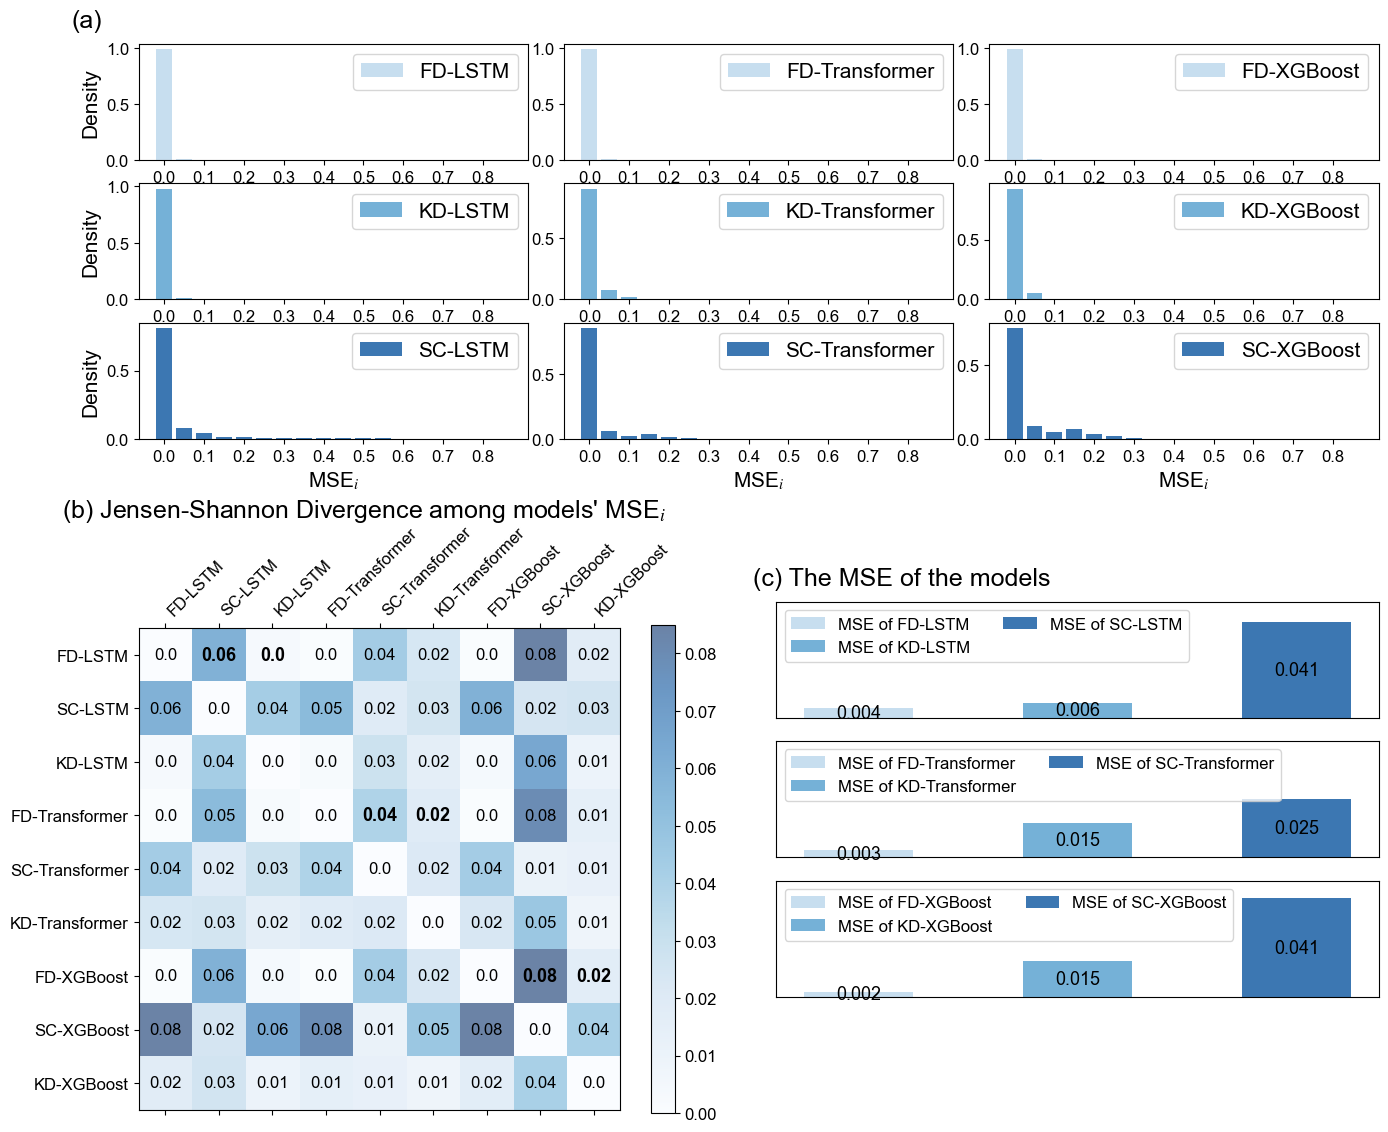

In [11]:
fig = plt.figure(dpi=100,
                 constrained_layout=True,#类似于tight_layout，使得各子图之间的距离自动调整【类似excel中行宽根据内容自适应】
                 figsize=(16,16)
                )
gs = GridSpec(9, 6, figure=fig)#GridSpec将fiure分为3行3列，每行三个axes，gs为一个matplotlib.gridspec.GridSpec对象，可灵活的切片figure

size=10

alphas = [0.8,0.8,0.8,0.8]
colors = ['#015482', '#61DE45', '#DEA13A', '#ff474c']#'#DE66C2''#5096DE'
colormap = plt.get_cmap('Blues')
colors   = colormap(np.linspace(0, 2, 8)).tolist() # 按百分比

dcolors = {'FD':colors[1],
           'KD':colors[2],
           'SC':colors[3]
           }

leg_size = 15
label_size = 15

xtext = 'MSE'+'$_{i}$'

# 第一列 LSTM的MSE分布
ax = fig.add_subplot(gs[0, 0:2])
ax.bar([i for i in range(FDLSTM_p1.shape[0])],FDLSTM_p1,color=dcolors['FD'],alpha=alphas[1],label='FD-LSTM')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

ax.text(-3.9, 1.25, '(a)', color='black', fontsize=18, ha='center', va='center')  # 在图内添加标题

ax = fig.add_subplot(gs[1, 0:2])
ax.bar([i for i in range(KDLSTM_p1.shape[0])],KDLSTM_p1,color=dcolors['KD'],alpha=alphas[2],label='KD-LSTM')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

ax = fig.add_subplot(gs[2, 0:2])
ax.bar([i for i in range(SCLSTM_p1.shape[0])],SCLSTM_p1,color=dcolors['SC'],alpha=alphas[3],label='SC-LSTM')
ax.set_xticks([i for i in range(0,SCLSTM_t.shape[0],2)], [str(np.round(i,3)) for i in SCLSTM_t[::2]])
ax.legend(fontsize=leg_size)
ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)



##############################################################################################
# 第二列 ATT的MSE分布

ax = fig.add_subplot(gs[0, 2:4])
ax.bar([i for i in range(FDATT_p1.shape[0])],FDATT_p1,color=dcolors['FD'],alpha=alphas[1],label='FD-Transformer')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)


ax = fig.add_subplot(gs[1, 2:4])
ax.bar([i for i in range(KDATT_p1.shape[0])],KDATT_p1,color=dcolors['KD'],alpha=alphas[2],label='KD-Transformer')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

ax = fig.add_subplot(gs[2, 2:4])
ax.bar([i for i in range(SCATT_p1.shape[0])],SCATT_p1,color=dcolors['SC'],alpha=alphas[3],label='SC-Transformer')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

##############################################################################################
# 第三列 XGB的MSE分布

ax = fig.add_subplot(gs[0, 4:])
ax.bar([i for i in range(FDXGB_p1.shape[0])],FDXGB_p1,color=dcolors['FD'],alpha=alphas[1],label='FD-XGBoost')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

ax = fig.add_subplot(gs[1, 4:])
ax.bar([i for i in range(KDXGB_p1.shape[0])],KDXGB_p1,color=dcolors['KD'],alpha=alphas[2],label='KD-XGBoost')
ax.set_xticks([i for i in range(0,SCATT_t.shape[0],2)], [str(np.round(i,3)) for i in SCATT_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)

ax = fig.add_subplot(gs[2, 4:])
ax.bar([i for i in range(SCXGB_p1.shape[0])],SCXGB_p1,color=dcolors['SC'],alpha=alphas[3],label='SC-XGBoost')
ax.set_xticks([i for i in range(0,SCXGB_t.shape[0],2)], [str(np.round(i,3)) for i in SCXGB_t[::2]])
ax.legend(fontsize=leg_size)
#ax.set_ylabel('Density',fontsize=label_size)
ax.set_xlabel(xtext,fontsize=label_size)


################################################################################################
# JS
ax = fig.add_subplot(gs[3:, :3])
#im = ax.matshow(JS, cmap = plt.cm.coolwarm,alpha=0.6)
im = ax.matshow(JS, cmap = plt.cm.Blues,alpha=0.6)
cbar = fig.colorbar(im, ax=ax, shrink=0.6) 

ax.text(3.7, -2.7, '(b) Jensen-Shannon Divergence among models\' '+xtext, color='black', fontsize=18, ha='center', va='center')  # 在图内添加标题
#ax.text(4, -2.5, 'Jensen-Shannon Divergence', color='black', fontsize=18, ha='center', va='center')  # 在图内添加标题

logblok = [(0,1),(0,2),(3,4),(3,5),(6,7),(6,8)]
for i in range(np.array(JS).shape[0]):  # 遍历行
    for j in range(np.array(JS).shape[1]):  # 遍历列
        if (i,j) in logblok:
            ax.text(j, i, np.round(np.array(JS)[i, j],2), ha='center', va='center', color='black', fontweight='bold', fontsize=13)
        else:
            ax.text(j, i, np.round(np.array(JS)[i, j],2), ha='center', va='center', color='black')

ax.set_xticks([i for i in range(len(JS))], ['FD-LSTM','SC-LSTM','KD-LSTM',
                                                'FD-Transformer','SC-Transformer','KD-Transformer',
                                                'FD-XGBoost','SC-XGBoost','KD-XGBoost'],rotation=45,ha='left')
ax.set_yticks([i for i in range(len(JS))], ['FD-LSTM','SC-LSTM','KD-LSTM',
                                                'FD-Transformer','SC-Transformer','KD-Transformer',
                                                'FD-XGBoost','SC-XGBoost','KD-XGBoost'])

#################################################################################################
#数据量和MSE
titlesize=15
xticksize=12
textsize=13

wid = 0.5

ax = fig.add_subplot(gs[4,3:])
ax.bar([0,1,2],[np.mean(alldataLSTM['mse']), np.mean(augdataLSTM['mse']), np.mean(scendataLSTM['mse'])],width=wid,alpha=alphas[1],
       color=[dcolors['FD'],dcolors['KD'],dcolors['SC']],label=['MSE of FD-LSTM','MSE of KD-LSTM','MSE of SC-LSTM'])
ax.set_ylim(0,0.05)
ax.text(0, np.mean(alldataLSTM['mse'])/2, str(np.round(np.mean(alldataLSTM['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(1, np.mean(augdataLSTM['mse'])/2, str(np.round(np.mean(augdataLSTM['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(2, np.mean(scendataLSTM['mse'])/2, str(np.round(np.mean(scendataLSTM['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
#ax.text(1, 0.21, 'MSE of LSTM', color='black', fontsize=titlesize, ha='center', va='center')  # 在图内添加标题
ax.set_xticks([])
ax.legend(fontsize=xticksize,ncol=2,loc='upper left')
ax.set_yticks([])

ax.text(0.2, 0.06, '(c) The MSE of the models', color='black', fontsize=18, ha='center', va='center')  # 在图内添加标题



ax = fig.add_subplot(gs[5,3:])
ax.bar([0,1,2],[np.mean(alldataATT['mse']), np.mean(augdataATT['mse']), np.mean(scendataATT['mse'])],width=wid,alpha=alphas[1],
       color=[dcolors['FD'],dcolors['KD'],dcolors['SC']],label=['MSE of FD-Transformer','MSE of KD-Transformer','MSE of SC-Transformer'])
ax.set_ylim(0,0.05)
ax.text(0, np.mean(alldataATT['mse'])/2, str(np.round(np.mean(alldataATT['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(1, np.mean(augdataATT['mse'])/2, str(np.round(np.mean(augdataATT['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(2, np.mean(scendataATT['mse'])/2, str(np.round(np.mean(scendataATT['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
#ax.text(1, 0.21, 'MSE of Transformer', color='black', fontsize=titlesize, ha='center', va='center')  # 在图内添加标题
ax.set_xticks([])
ax.legend(fontsize=xticksize,ncol=2,loc='upper left')
ax.set_yticks([])


ax = fig.add_subplot(gs[6,3:])
ax.bar([0,1,2],[np.mean(alldataXGB['mse']), np.mean(augdataXGB['mse']), np.mean(scendataXGB['mse'])],width=wid,alpha=alphas[1],
       color=[dcolors['FD'],dcolors['KD'],dcolors['SC']],label=['MSE of FD-XGBoost','MSE of KD-XGBoost','MSE of SC-XGBoost'])
ax.set_ylim(0,0.048)
ax.text(0, np.mean(alldataXGB['mse'])/2, str(np.round(np.mean(alldataXGB['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(1, np.mean(augdataXGB['mse'])/2, str(np.round(np.mean(augdataXGB['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
ax.text(2, np.mean(scendataXGB['mse'])/2, str(np.round(np.mean(scendataXGB['mse']),3)), 
        color='black', fontsize=textsize, ha='center', va='center')  # 在图内添加标题
#ax.text(1, 0.21, 'MSE of XGBoost', color='black', fontsize=titlesize, ha='center', va='center')  # 在图内添加标题
ax.set_xticks([])
ax.legend(fontsize=xticksize,ncol=2,loc='upper left')
ax.set_yticks([])

plt.savefig('./MSE_dis_JS.png',dpi=100,bbox_inches='tight')